<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to predict the future 24 hours of energy demand. This is a multivariate time series forecasting project.

##  1. Data Preprocessing


### 1-1. Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])

In [4]:
df.shape

(35064, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB


In [6]:
df.head()

,time,total load actual,price actual
0,2015-01-01 00:00:00+01:00,25385.0,65.41
1,2015-01-01 01:00:00+01:00,24382.0,64.92
2,2015-01-01 02:00:00+01:00,22734.0,64.48
3,2015-01-01 03:00:00+01:00,21286.0,59.32
4,2015-01-01 04:00:00+01:00,20264.0,56.04


### 1-2. Managing Time Column

In [7]:
# Manage time column

# I usually set the datetime as the index. You may keep the origional index and datetime column,
# then you just need to use datetime column instead of index later, when selecting data.

# Case X
#df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
#df.drop(['Date', 'Time'], axis=1, inplace=True)
#df.set_index('datetime', inplace=True)
df['time'] = pd.to_datetime(df['time'], utc=True)

df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is sorted
df.sort_index(inplace=True)

# Calculate time differences

time_diffs = df.index.to_series().diff()

# Identify any irregularities, apart from the first row
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]

# Display irregularities, if any
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


### 1-3. Handling Missing Values

In [8]:
# Replacing Specific Non-Numeric Values with NaN

# List of non-numeric values to replace
non_numeric_values = ['?', 'N/A', '-', '']

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')

In [9]:
# Check out null value situation
df.isna().sum()

,0
total load actual,36
price actual,0


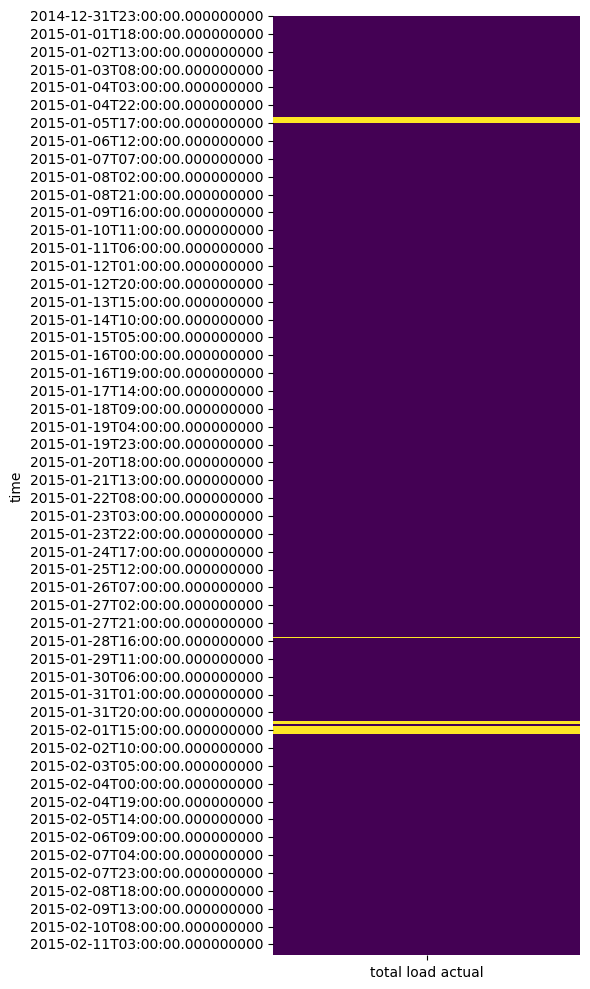

In [10]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.heatmap(df['total load actual'][:1000].isna().to_frame(), cbar=False, cmap='viridis', ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Impute the missing values with interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

In [12]:
df.isna().sum()

,0
total load actual,0
price actual,0


### 1-4. Formating Data Types

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  35064 non-null  float64
 1   price actual       35064 non-null  float64
dtypes: float64(2)
memory usage: 821.8 KB


## 2. EDA

### 2-1. Visualizing Data

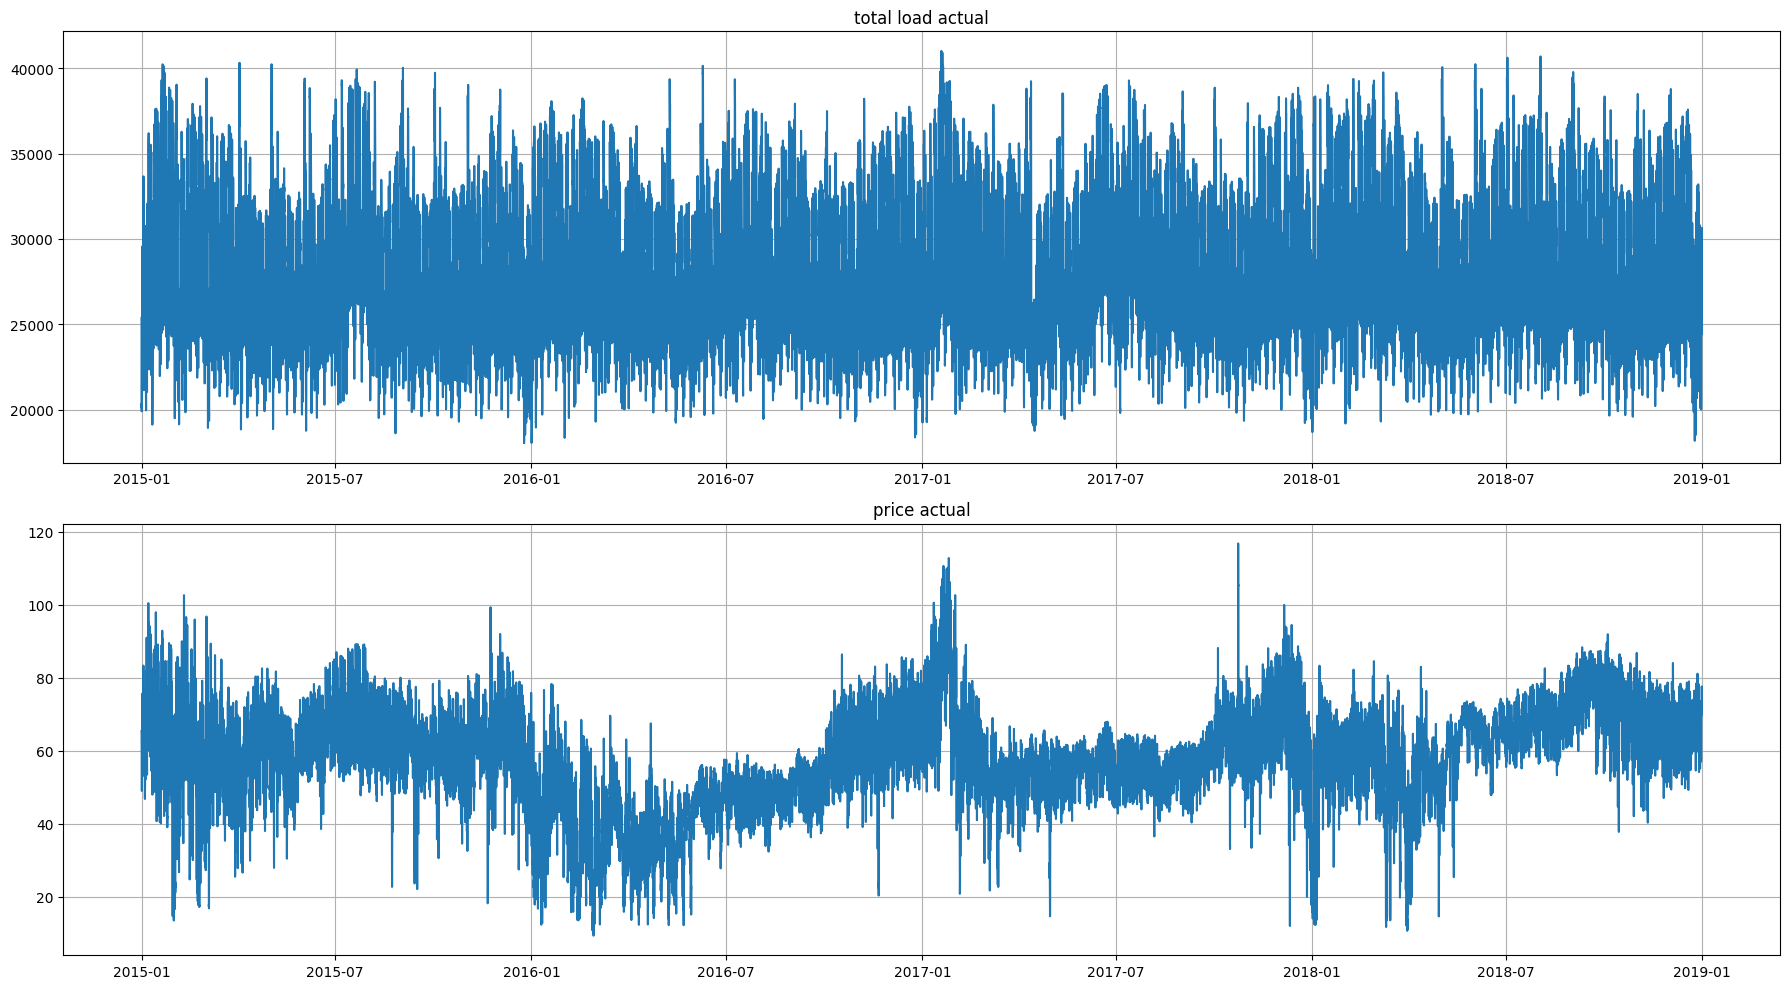

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

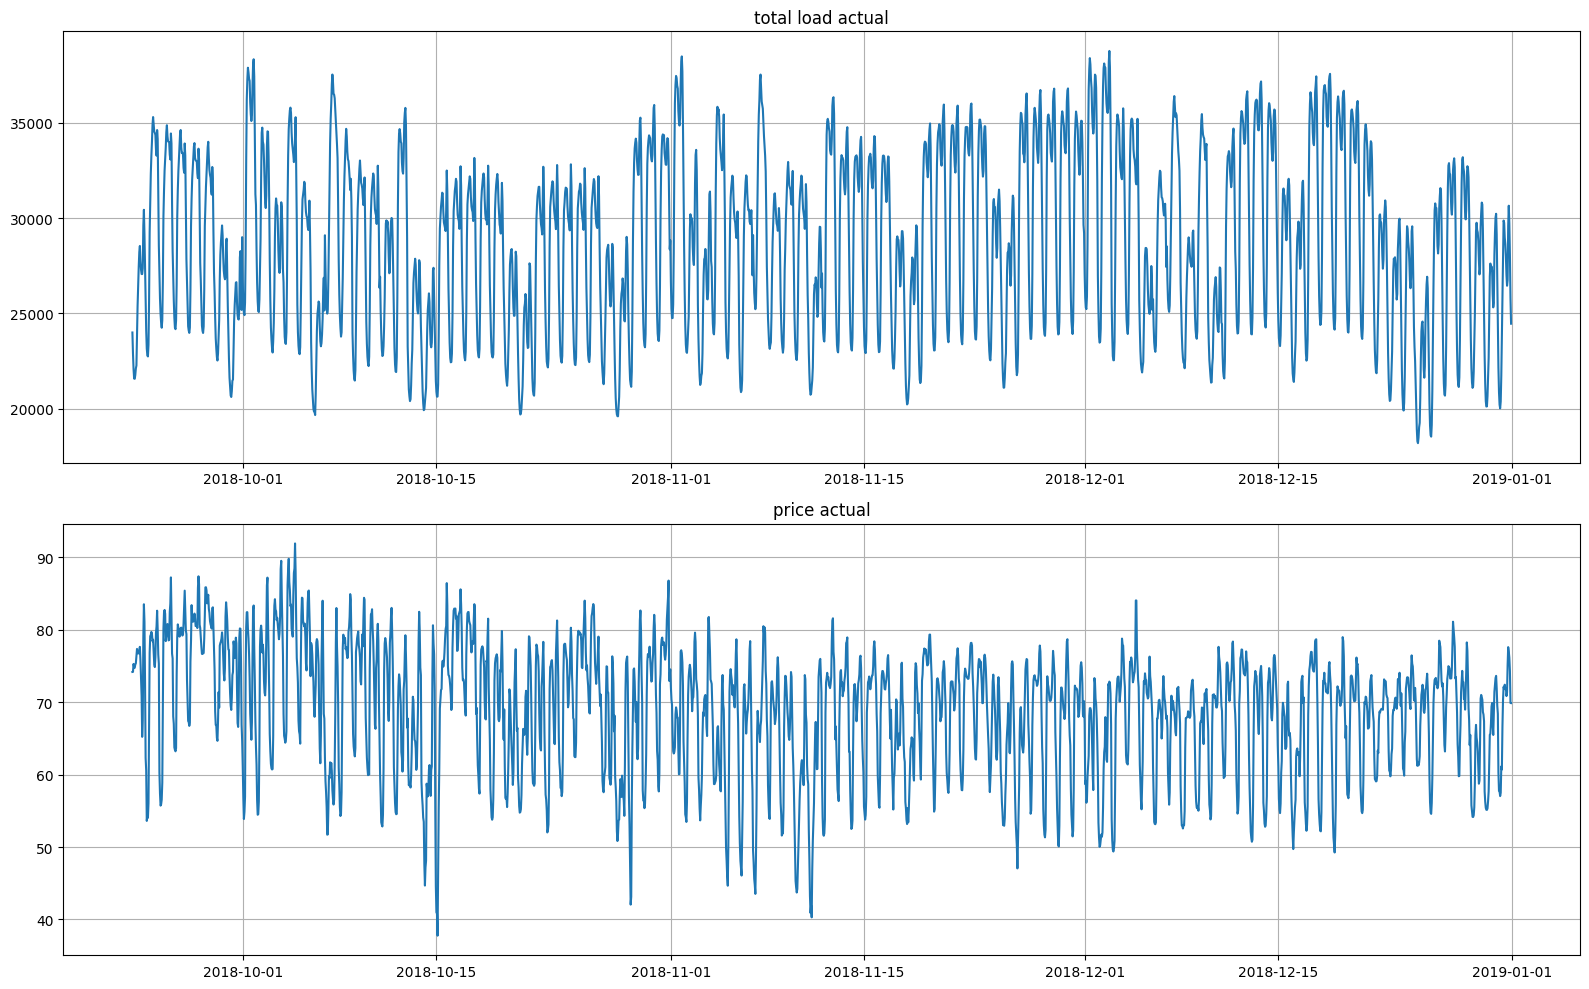

In [15]:
# Visualize a few data at the end

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

for i, col in enumerate(df.columns[:]):
    axs[i].plot(df[col][-24*100:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### 2-2 Statistics of the Dataset

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,35064.0,28698.281385,4575.828854,18041.00,24807.0000,28902.00,32194.25,41015.0
price actual,35064.0,57.884023,14.204083,9.33,49.3475,58.02,68.01,116.8


From the statistics, we can see that two features are in different scale, we need to do a scaling before fitting a model.

In [17]:
df.corr()

,total load actual,price actual
total load actual,1.000000,0.435253
price actual,0.435253,1.000000


### 2-3 Data Preparation

#### 2-3-1 Features Selection

In [18]:
df.columns.to_list()

['total load actual', 'price actual']

In [19]:
# Since there are only two features, both of them are useful, no need to select features.

used_cols = ['total load actual', 'price actual']

# Smoth the features
for col in used_cols:
    df[f'{col}_roll'] = df[col].rolling(window=3).mean()
df.dropna(inplace=True)


#### 2-3-2 Train Test Split

In [20]:
split_step = int(len(df)*0.8)
train = df.iloc[:split_step]
val = df.iloc[split_step:]

valid = val.iloc[:int(len(val)*0.5)].copy()
test = val.iloc[int(len(val)*0.5):].copy()

#### 2-3-3 Normalization

In [87]:
# Example: Applying Min-Max Scaling to your dataset


# We use the rolling values instead of original values as input variables
roll_cols = ['total load actual_roll', 'price actual_roll']

# Initialize the scalers
input_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

# Avoid SettingWithCopyWarning by assigning results directly back to the DataFrame
for col in roll_cols:
    train.loc[:,f'{col}_scaled'] = input_scaler.fit_transform(train[[col]].copy())
    valid.loc[:,f'{col}_scaled'] = input_scaler.transform(valid[[col]].copy())
    test.loc[:,f'{col}_scaled'] = input_scaler.transform(test[[col]].copy())

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']].copy())
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']].copy())

valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']].copy())
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']].copy())

test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']].copy())
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']].copy())

<ipython-input-87-788618d9152b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,f'{col}_scaled'] = input_scaler.fit_transform(train[[col]].copy())
<ipython-input-87-788618d9152b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,f'{col}_scaled'] = input_scaler.fit_transform(train[[col]].copy())
<ipython-input-87-788618d9152b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

#### 2-3-4 Generate Dataset for Models



```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



##### Single Step

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, feature_columns, label_columns, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      label_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        feature_columns = [column_names.index(col) if isinstance(col, str) else col for col in feature_columns]
        label_columns = [column_names.index(col) if isinstance(col, str) else col for col in label_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], feature_columns, axis=-1),
                                          tf.gather(window[-1], label_columns, axis=-1)))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset





Single Step Single Output



In [24]:
column_names = dr.columns.to_list()
input_cols = ['total load actual_roll', 'price actual_roll']
target_cols = ['total load actual']
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size, feature_columns=input_cols, label_columns=target_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 60, 5)
shape of second element: (32, 1)

```

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build the RNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(input_cols)]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(1),
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - loss: 750312000.0000
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


KeyboardInterrupt: 

In [ ]:
def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series.iloc[:,:-1]) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
forecast = model_forecast(model, val, window_size, batch_size)

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
actual = val.iloc[window_size:,-1].to_list()

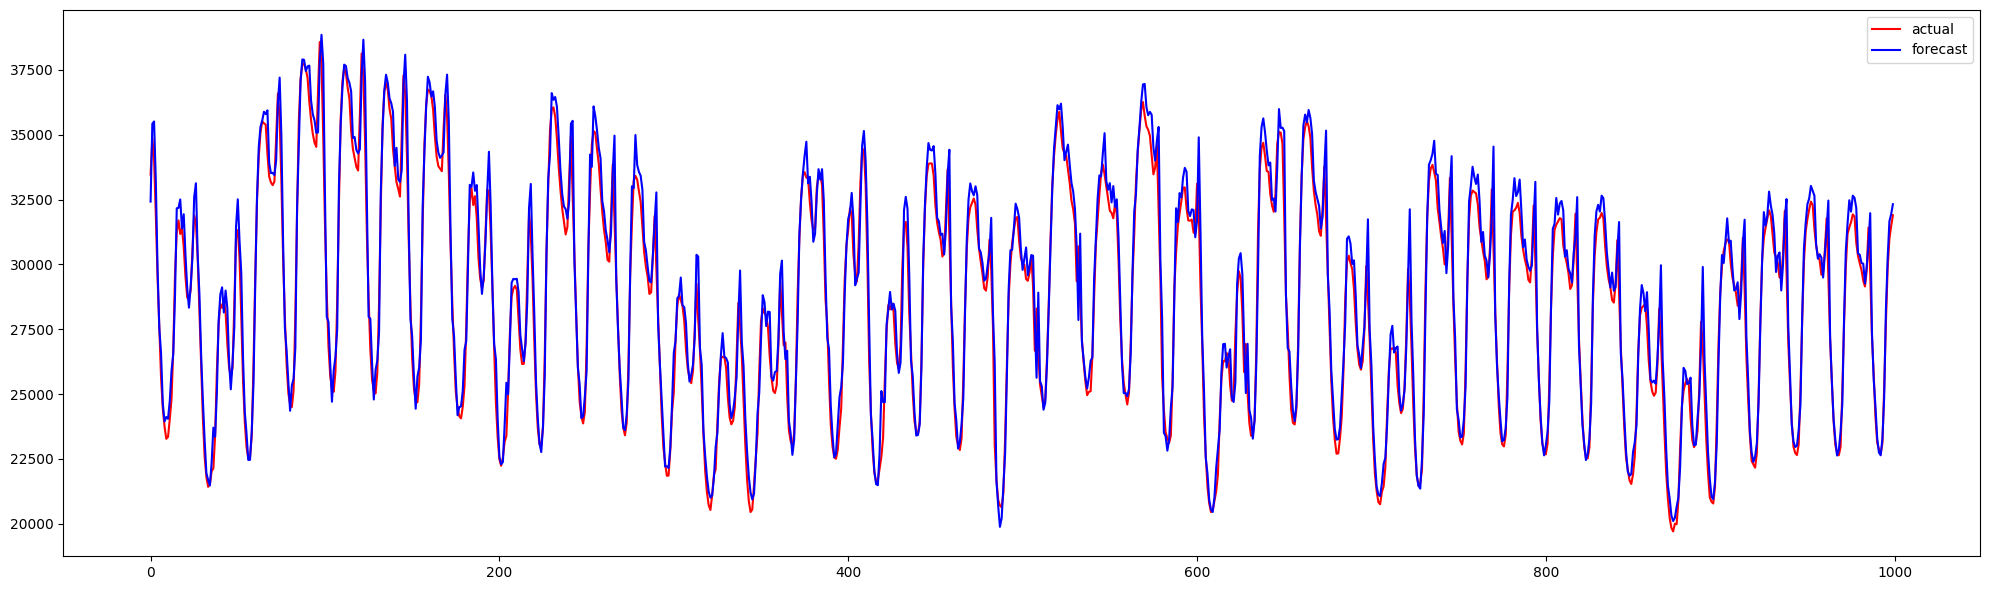

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='actual')
ax.plot(forecast[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual, forecast[:-1])
mae = mean_absolute_error(actual, forecast[:-1])

print(f'mse: {mse}')
print(f'mae: {mae}')

mse: 775539.459801751
mae: 638.5030571383704


Single Step Multi-Output

In [ ]:
column_names = dr.columns.to_list()
input_cols = ['total load actual_roll', 'price actual_roll']
target_cols = ['total load actual','price actual']
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size, feature_columns=input_cols, label_columns=target_cols, column_names=column_names)

```
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 2)
```

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten


# Build CNN-LSTM-DNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu',
                          input_shape=[window_size, len(input_cols)]),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
model.fit(train_set, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 364030336.0000
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


877/877 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 110050680.0000
Epoch 3/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 13428641.0000
Epoch 4/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 10538354.0000
Epoch 5/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 10643668.0000
Epoch 6/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 10506933.0000
Epoch 7/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 10514083.0000
Epoch 8/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 10453277.0000
Epoch 9/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9187261.0000
Epoch 10/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 637877.1875
Epoch 11/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 435872.3438
Epoch 12/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 413240.6250
Epoch 13/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 417022.7500
Epoch 14/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 392528.9688
Epoch 15/30
877/877 ━━━━━━━━━━━━━━

In [ ]:
def model_forecast(model, series,feature_columns, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      feature_columns (list of str or int) - the names or indices of the columns to be used as features
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      Forecast
    """


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series[feature_columns])

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast


In [ ]:
forecast = model_forecast(model=model, series=val, feature_columns=input_cols, window_size=window_size, batch_size=batch_size)

214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
forecast[:10]

array([[33044.445   ,    57.970284],
       [35736.418   ,    62.147213],
       [37942.465   ,    65.96601 ],
       [35338.15    ,    61.593246],
       [31836.05    ,    56.299828],
       [27483.523   ,    51.265503],
       [26456.973   ,    49.02615 ],
       [25122.248   ,    48.93841 ],
       [24540.568   ,    48.795856],
       [24173.105   ,    48.278683]], dtype=float32)

In [ ]:
val.columns

Index(['total load actual_roll', 'price actual_roll', 'total load actual',
       'price actual'],
      dtype='object')

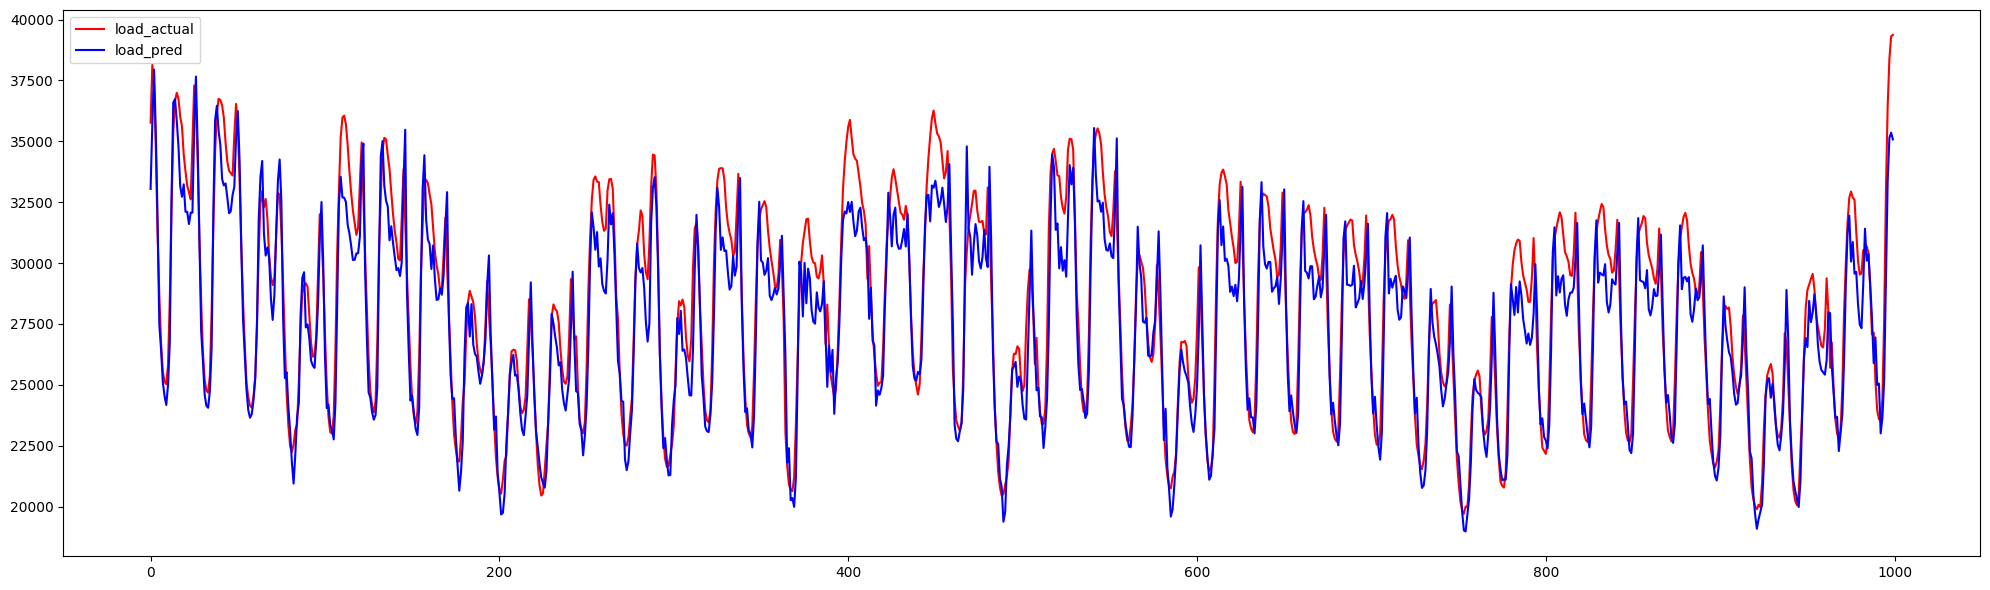

In [ ]:
price_pred = forecast[:-1,0]
actual = val['total load actual'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
price_pred = forecast[:-1,0]
actual = val['total load actual'][window_size:].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual[:1000], c='red', label='load_actual')
ax.plot(price_pred[:1000], c= 'blue', label='load_pred')
plt.legend()
plt.tight_layout()
plt.show()

##### multi_step

multi_step_multi-output

This is the most general case, all other cases are just special case of this situation

In [88]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1)))

    if shuffle_buffer_size is not None:
        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset



In [89]:
input_cols = ['total load actual_roll_scaled', 'price actual_roll_scaled']
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

train_s = train[input_cols + output_cols].copy()
valid_s = valid[input_cols + output_cols].copy()
test_s = test[input_cols + output_cols].copy()

# Parameters
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 10000 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

In [31]:
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 48, 2)
shape of second element: (32, 24, 2)


## 3. Model Training

### CNN-LSTM-DNN

In [34]:
# Build CNN-LSTM-DNN Model

def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Lambda(lambda x: x[:,-forecast_size:,:])
    ])

    return model

def adjust_learning_rate(dataset):
    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    # Train the model
    history = model.fit(dataset, epochs=80, callbacks=[lr_schedule])

    return history


In [35]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - loss: 0.0752 - mae: 0.3360 - learning_rate: 1.0000e-04
Epoch 2/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 85s 55ms/step - loss: 0.0163 - mae: 0.1447 - learning_rate: 1.1220e-04
Epoch 3/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - loss: 0.0145 - mae: 0.1385 - learning_rate: 1.2589e-04
Epoch 4/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - loss: 0.0144 - mae: 0.1379 - learning_rate: 1.4125e-04
Epoch 5/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - loss: 0.0144 - mae: 0.1375 - learning_rate: 1.5849e-04
Epoch 6/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 0.0142 - mae: 0.1369 - learning_rate: 1.7783e-04
Epoch 7/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - loss: 0.0142 - mae: 0.1363 - learning_rate: 1.9953e-04
Epoch 8/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - loss: 0.0141 - mae: 0.1360 - learning_rate: 2.2387e-04
Epoch 9/80
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 0.0140 - mae: 0.1354 - learning_rate: 2.5119e-04
E

(0.0001, 1.0, 0.0, 0.08)

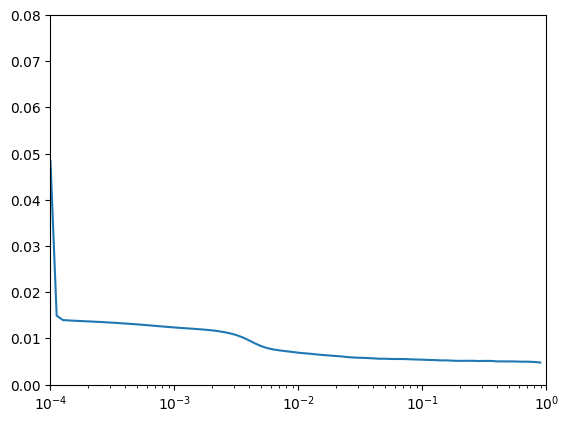

In [42]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 1, 0, 0.08])

In [91]:
valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [93]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=4e-1, momentum=0.9),
                  metrics=["mae"])
    return model

model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - loss: 0.0160 - mae: 0.1405 - val_loss: 0.0066 - val_mae: 0.0850
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 61ms/step - loss: 0.0066 - mae: 0.0877 - val_loss: 0.0057 - val_mae: 0.0791
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - loss: 0.0060 - mae: 0.0825 - val_loss: 0.0052 - val_mae: 0.0734
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - loss: 0.0057 - mae: 0.0802 - val_loss: 0.0053 - val_mae: 0.0744
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 113s 94ms/step - loss: 0.0056 - mae: 0.0792 - val_loss: 0.0047 - val_mae: 0.0694
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 93s 96ms/step - loss: 0.0055 - mae: 0.0781 - val_loss: 0.0055 - val_mae: 0.0747
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - loss: 0.0054 - mae: 0.0778 - val_loss: 0.0047 - val_mae: 0.0689
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 0.0053 - mae: 0.0763 - val_loss: 0.0051 - val_mae: 0.0724
Epoch 9/30
875/875 ━━━━━━━━━━━━━━━━━━━━

In [96]:
prediction = model.predict(test_input)

test_set = windowed_dataset( series = test_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)
test_input = test_set.map(lambda x, y: x)
test_y = test_set.map(lambda x, y: y)

test_output = []
for outputs in test_y:
    test_output.append(outputs.numpy())
test_output = np.concatenate(test_output, axis=0)

### XGBoost

In [21]:
df.head()

,total load actual,price actual,total load actual_roll,price actual_roll
time,,,,
2015-01-01 01:00:00,22734.0,64.48,24167.000000,64.936667
2015-01-01 02:00:00,21286.0,59.32,22800.666667,62.906667
2015-01-01 03:00:00,20264.0,56.04,21428.000000,59.946667
2015-01-01 04:00:00,19905.0,53.63,20485.000000,56.330000
2015-01-01 05:00:00,20010.0,51.73,20059.666667,53.800000


In [22]:
import holidays


def create_features(mother_dataset):
    """
    Create time series features from the datetime index and existing variables
    """
    df = mother_dataset.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Use Spain holidays
    spain_holidays = holidays.Spain()
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in spain_holidays else 0)

    for lag in range(1, 25):
        df[f'load_lag_{lag}'] = df['total load actual'].shift(lag)
        df[f'price_lag_{lag}'] = df['price actual'].shift(lag)
    # Dropping NaN values resulting from rolling operation
    df.dropna(inplace=True)

    return df



In [23]:
df = df.drop(['total load actual_roll','price actual_roll'], axis=1)
ds = create_features(df)
ds.head()

,total load actual,price actual,hour,dayofweek,quarter,month,dayofmonth,dayofyear,is_month_start,is_month_end,...,load_lag_20,price_lag_20,load_lag_21,price_lag_21,load_lag_22,price_lag_22,load_lag_23,price_lag_23,load_lag_24,price_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 01:00:00,23214.0,54.70,1,4,1,1,2,2,0,0,...,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32,22734.0,64.48
2015-01-02 02:00:00,22540.0,54.91,2,4,1,1,2,2,0,0,...,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04,21286.0,59.32
2015-01-02 03:00:00,22096.0,53.07,3,4,1,1,2,2,0,0,...,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63,20264.0,56.04
2015-01-02 04:00:00,22066.0,54.23,4,4,1,1,2,2,0,0,...,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73,19905.0,53.63
2015-01-02 05:00:00,22275.0,58.22,5,4,1,1,2,2,0,0,...,22250.0,58.94,20637.0,54.20,20094.0,48.98,20377.0,51.43,20010.0,51.73


In [24]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35038 entries, 2015-01-02 01:00:00 to 2018-12-31 22:00:00
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  35038 non-null  float64
 1   price actual       35038 non-null  float64
 2   hour               35038 non-null  int32  
 3   dayofweek          35038 non-null  int32  
 4   quarter            35038 non-null  int32  
 5   month              35038 non-null  int32  
 6   dayofmonth         35038 non-null  int32  
 7   dayofyear          35038 non-null  int32  
 8   is_month_start     35038 non-null  int64  
 9   is_month_end       35038 non-null  int64  
 10  is_quarter_start   35038 non-null  int64  
 11  is_quarter_end     35038 non-null  int64  
 12  is_weekend         35038 non-null  int64  
 13  is_holiday         35038 non-null  int64  
 14  load_lag_1         35038 non-null  float64
 15  price_lag_1        35038 non-null  

In [25]:
ds.shape

(35038, 62)

In [26]:
split_step = int(len(ds)*0.8)
train = ds.iloc[:split_step]
val = ds.iloc[split_step:]

valid = val.iloc[:int(len(val)*0.5)].copy()
test = val.iloc[int(len(val)*0.5):].copy()

In [27]:
train_x = train.drop(['total load actual', 'price actual'], axis=1)
train_load = train['total load actual']
train_price = train['price actual']

valid_x = valid.drop(['total load actual', 'price actual'], axis=1)
valid_load = valid['total load actual']
valid_price = valid['price actual']

test_x = test.drop(['total load actual', 'price actual'], axis=1)
test_load = test['total load actual']
test_price = test['price actual']

In [28]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(3, 5, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))



Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.2, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0}
Lowest RMSE for total load actual:  551.8266897813725


In [30]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 2, 3),
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [1000, 1300],
    'min_child_weight': [4, 5, 6],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1, 0.2, 0.3]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 1300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.3, 'gamma': 0.1}
Lowest RMSE for total load actual:  728.3072190329862


In [31]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 2),
    'learning_rate': [0.3, 0.4, 0.5],
    'n_estimators': [1300],
    'min_child_weight': [5],
    'gamma': [0.1],
    'reg_alpha': [0.1],
    'reg_lambda': [0.05, 0.1]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.05, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 1300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.5, 'gamma': 0.1}
Lowest RMSE for total load actual:  708.1392764632178


In [32]:
dtrain = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.05,
              'reg_alpha': 0.1,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 1,
              'learning_rate': 0.5,
              'gamma': 0.1}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

[0]	train-mae:2664.67749+7.85685	train-rmse:3287.19840+9.24827	test-mae:2666.69327+32.56587	test-rmse:3288.61799+39.26311
[200]	train-mae:599.65362+2.68634	train-rmse:819.16192+5.25148	test-mae:612.88018+6.28907	test-rmse:836.12924+18.11092
[400]	train-mae:534.54747+1.78231	train-rmse:746.73755+5.44574	test-mae:548.97423+6.97314	test-rmse:766.29871+19.73421
[600]	train-mae:505.80266+2.39039	train-rmse:716.02799+5.23349	test-mae:521.78101+6.85009	test-rmse:738.26588+20.53457
[800]	train-mae:488.79373+2.26106	train-rmse:697.78386+5.21704	test-mae:505.87526+6.98899	test-rmse:721.78846+20.97293
[1000]	train-mae:477.52819+2.47344	train-rmse:685.41416+5.20400	test-mae:496.05445+6.72359	test-rmse:711.40207+21.71589
[1200]	train-mae:468.96590+2.51221	train-rmse:676.15037+5.18763	test-mae:488.59114+6.84079	test-rmse:703.81181+22.24007
[1400]	train-mae:462.28045+2.45705	train-rmse:668.78183+5.21632	test-mae:482.89315+6.75875	test-rmse:697.85427+22.49625
[1600]	train-mae:456.90425+2.55237	train-r

## 4. Evaluation

In [117]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Reshape the predictions and valid outputs to 2D
# This flattens the windows and time steps into a single dimension
prediction_reshaped = prediction.reshape(-1, prediction.shape[-1])  # Shape: (6966*24, 2)
test_output_reshaped = test_output.reshape(-1, test_output.shape[-1])  # Shape: (6966*24, 2)

# Revert the predictions and actual values to their original scales
prediction_reshaped[:, 0] = load_scaler.inverse_transform(prediction_reshaped[:, 0].reshape(-1, 1)).flatten()
prediction_reshaped[:, 1] = price_scaler.inverse_transform(prediction_reshaped[:, 1].reshape(-1, 1)).flatten()

test_output_reshaped[:, 0] = load_scaler.inverse_transform(test_output_reshaped[:, 0].reshape(-1, 1)).flatten()
test_output_reshaped[:, 1] = price_scaler.inverse_transform(test_output_reshaped[:, 1].reshape(-1, 1)).flatten()

# Calculate MSE for each target
mse_load = mean_squared_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mse_price = mean_squared_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Calculate MAE for each target
mae_load = mean_absolute_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mae_price = mean_absolute_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Print the MSE results
print(f'MSE for Load: {mse_load}')
print(f'MSE for Price: {mse_price}')

# Print the MAe results
print(f'MAE for Load: {mae_load}')
print(f'MAE for Price: {mae_price}')

MSE for Load: 7109858.220131684
MSE for Price: 32.32858569674062
MAE for Load: 2032.1090146865224
MAE for Price: 4.537975513299491


## 5. |Deployment and Prediction

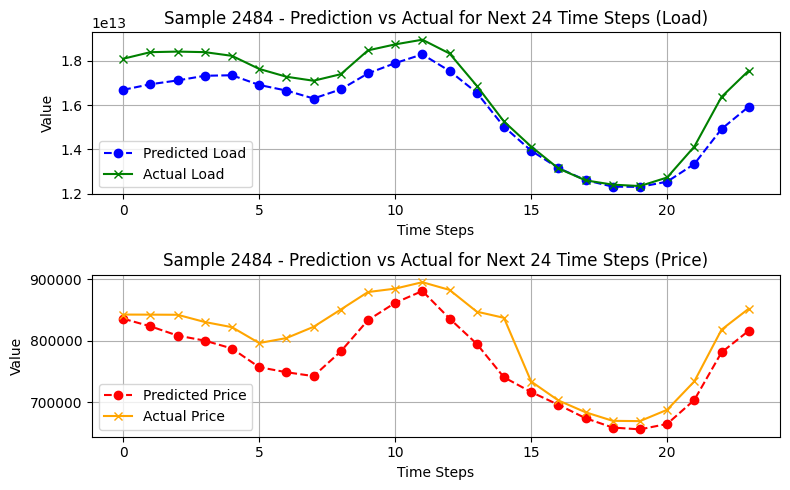

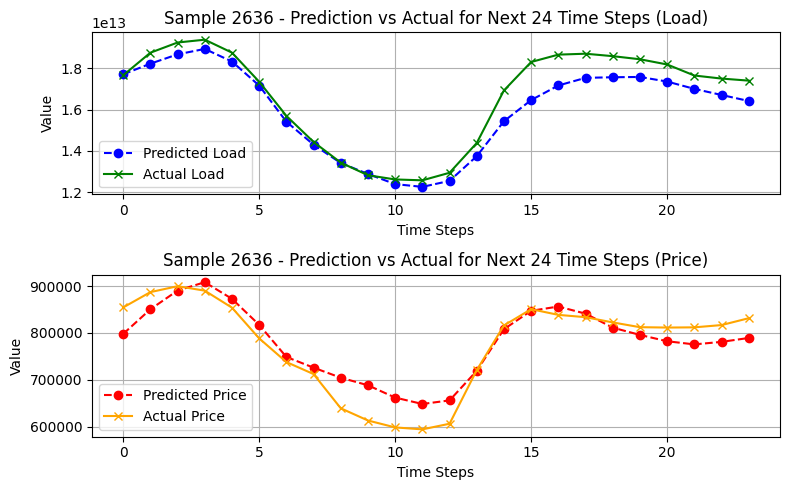

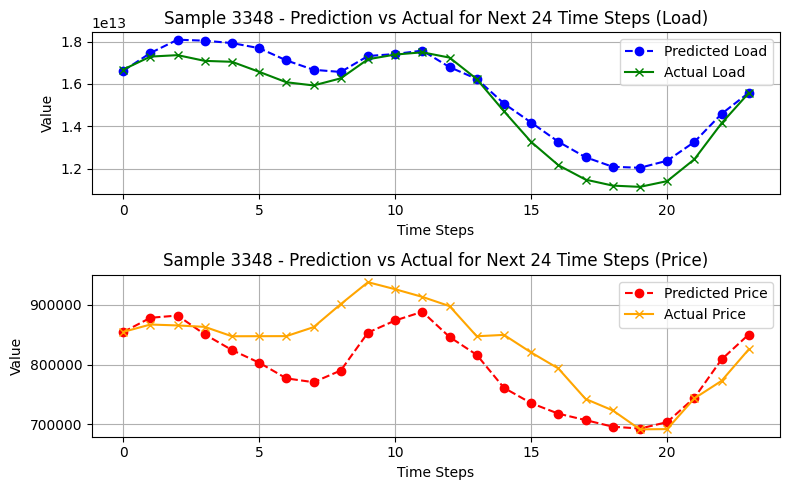

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 3 samples (indices) from the reshaped predictions and valid outputs
num_samples = prediction.shape[0]  # This is 6966 based on your description
random_indices = np.random.choice(num_samples, 3, replace=False)

# Plot predictions vs actual values for the selected samples in original scale
for i, idx in enumerate(random_indices):
    # Revert the predictions and actual values for the selected sample
    original_prediction_load = load_scaler.inverse_transform(prediction[idx, :, 0].reshape(-1, 1)).flatten()
    original_actual_load = load_scaler.inverse_transform(test_output[idx, :, 0].reshape(-1, 1)).flatten()

    original_prediction_price = price_scaler.inverse_transform(prediction[idx, :, 1].reshape(-1, 1)).flatten()
    original_actual_price = price_scaler.inverse_transform(test_output[idx, :, 1].reshape(-1, 1)).flatten()

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    axs[0].plot(original_prediction_load, label='Predicted Load', linestyle='--', marker='o', c='blue')
    axs[0].plot(original_actual_load, label='Actual Load', linestyle='-', marker='x', c='green')
    axs[0].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Load)')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(original_prediction_price, label='Predicted Price', linestyle='--', marker='o', c='red')
    axs[1].plot(original_actual_price, label='Actual Price', linestyle='-', marker='x', c= 'orange')
    axs[1].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Price)')
    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

